# RNNs to Transformers
This notebook shows how to create models that translate from french to english

I will slowly build up the complexity of the model:
1. Starting with a seq2seq architecture without attention,
2. Adding in attention,
3. Then using a transformer

In [83]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation
Using the dataset/data prep code in this tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [3]:
!curl https://download.pytorch.org/tutorial/data.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  27.2M      0 --:--:-- --:--:-- --:--:-- 27.2M


In [5]:
!unzip data.zip -d ./

Archive:  data.zip
  inflating: ./data/eng-fra.txt      
   creating: ./data/names/
  inflating: ./data/names/Arabic.txt  
  inflating: ./data/names/Chinese.txt  
  inflating: ./data/names/Czech.txt  
  inflating: ./data/names/Dutch.txt  
  inflating: ./data/names/English.txt  
  inflating: ./data/names/French.txt  
  inflating: ./data/names/German.txt  
  inflating: ./data/names/Greek.txt  
  inflating: ./data/names/Irish.txt  
  inflating: ./data/names/Italian.txt  
  inflating: ./data/names/Japanese.txt  
  inflating: ./data/names/Korean.txt  
  inflating: ./data/names/Polish.txt  
  inflating: ./data/names/Portuguese.txt  
  inflating: ./data/names/Russian.txt  
  inflating: ./data/names/Scottish.txt  
  inflating: ./data/names/Spanish.txt  
  inflating: ./data/names/Vietnamese.txt  


In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" : 1, "EOS" : 2}
        self.word2count = {}
        self.index2word = {1: "SOS", 2: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            idx = self.n_words+1
            self.word2index[word] = idx
            self.word2count[word] = 1
            self.index2word[idx] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # adds a space before puncutation, because there has to be a space between each token.  
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # replaces punctuation (e.g. apostrophes) with a space
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


french_lang, english_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis en train de dormir .', 'i m sleeping .']


In [3]:
def convert_to_tensor(lang, sentence):
    sentence = [lang.word2index[word] for word in sentence.split(' ')]
    sentence.append(lang.word2index["EOS"])
    return torch.tensor(sentence, dtype=torch.long)


class SentenceDataset(Dataset):
    def __init__(self, lang1, lang2, pairs):
        self.lang1 = lang1
        self.lang2 = lang2
        self.pairs = []
        for i in range(len(pairs)):
            s1, s2 = pairs[i]
            self.pairs.append([convert_to_tensor(lang1, s1), convert_to_tensor(lang2,s2)])
    def __getitem__(self, idx):
        return self.pairs[idx][0], self.pairs[idx][1]
    def __len__(self):
        return len(self.pairs)

def pad_collate(batch):
    x, y = zip(*batch)
    x_lens = torch.tensor([len(i) for i in x])
    y_lens = torch.tensor([len(i) for i in y])
    x_pad = pad_sequence(x, padding_value=0)
    y_pad = pad_sequence(y, padding_value=0)
    
    # sort 
    x_lens, idx = x_lens.sort(0, descending=True)
    y_lens = y_lens[idx]
    x_pad = x_pad[:, idx]
    y_pad = y_pad[:, idx]
    
    return x_pad, y_pad, x_lens, y_lens

dataset = SentenceDataset(french_lang, english_lang, pairs)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

In [4]:
pairs[2]

['ca va .', 'i m ok .']

In [5]:
dataset[10]

(tensor([ 7, 12, 22,  6,  2]), tensor([ 3,  4, 13,  5,  2]))

In [6]:
next(iter(data_loader)) # sentence length x batch_size

(tensor([[ 7,  3,  7,  7,  7,  7,  7,  7,  7,  7, 36,  3,  7,  7,  7,  7,  7,  7,
          25,  7,  7,  7,  7,  7,  7,  7,  7,  7,  3, 28, 10, 10],
         [12, 15,  8, 12, 12, 12, 12, 12, 12,  8, 11,  4, 12, 12, 12, 12, 12, 12,
          26, 12, 12, 12, 12, 12, 12, 12, 12, 12,  4, 29, 11, 11],
         [15,  4,  9, 41, 40, 39, 38, 37, 37,  9,  9, 34, 33, 32, 31, 30, 27, 13,
          23, 24, 23, 22, 21, 20, 19, 17, 14, 13,  5,  6,  6,  6],
         [16, 35,  6,  6, 18, 18,  6,  6, 18,  6,  6,  6,  6,  6,  6,  6,  6,  6,
           6,  6,  6,  6,  6,  6, 18, 18,  6,  6,  6,  2,  2,  2],
         [ 6,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0],
         [ 2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          15,  3,  3, 

## 1. Basic RNN Model

In [7]:
# packing sequences: https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

class EncoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(dict_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, x, lens):
        input = self.embedding(x)
        input = pack_padded_sequence(input, lens)
        output, hidden = self.gru(input, torch.zeros(1, x.shape[1], self.hidden_size))
        return output, hidden 
    
class DecoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(dict_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, dict_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        input = self.embedding(x)
        input = F.relu(input)
        output, hidden = self.gru(input, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [8]:
hidden_size = 256
learning_rate = 0.05
encoder = EncoderRNN(french_lang.n_words+1, hidden_size)
decoder = DecoderRNN(english_lang.n_words+1, hidden_size) #+1 required for padding token (token 0)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0) # should not calculate loss if the ith word is a padding token (0)

In [11]:
SOSToken = 1
EOSToken = 2

def step(x, y, x_lens, y_lens):
    encoder.train(True)
    decoder.train(True)
    encoder_outputs, decoder_hidden = encoder(x, x_lens) # last encoder hidden state becomes decoder hidden state
    decoder_input = torch.full((1, decoder_hidden.shape[1]), english_lang.word2index['SOS'])
    # no teacher forcing for now, could add in later
    loss = 0
    target_length = max(y_lens)
    for i in range(target_length):
        # decoder_input: (1 x 32 x 1)
        # decoder_hidden: (1 x 32 x 256)
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        # decoder_output: (32 x dict_size)
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        
        loss += criterion(decoder_output, y[i, :].squeeze()).sum() 
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    return loss.item() / target_length


def run_epoch(data_loader):
    total_loss = 0
    num_iters = 0
    for x, y, x_lens, y_lens in tqdm(data_loader):
        total_loss += step(x, y, x_lens, y_lens)
        num_iters += 1
    return total_loss/num_iters

def train(data_loader, num_epochs=30):
    losses = []
    for i in range(num_epochs):
        losses.append(run_epoch(data_loader))
        print(f"Loss: {losses[-1]}")
    return losses
        
losses = train(data_loader, num_epochs=15)

100%|██████████| 332/332 [00:07<00:00, 43.26it/s]


Loss: 1.036394715309143


100%|██████████| 332/332 [00:07<00:00, 43.38it/s]


Loss: 0.9837220907211304


100%|██████████| 332/332 [00:07<00:00, 43.39it/s]


Loss: 0.9020172357559204


100%|██████████| 332/332 [00:07<00:00, 43.40it/s]


Loss: 0.8330768346786499


100%|██████████| 332/332 [00:07<00:00, 43.38it/s]


Loss: 0.7824727296829224


100%|██████████| 332/332 [00:07<00:00, 43.40it/s]


Loss: 0.7602018713951111


100%|██████████| 332/332 [00:07<00:00, 43.46it/s]


Loss: 0.7024868130683899


100%|██████████| 332/332 [00:07<00:00, 43.60it/s]


Loss: 0.6708623766899109


100%|██████████| 332/332 [00:07<00:00, 43.70it/s]


Loss: 0.606452226638794


100%|██████████| 332/332 [00:07<00:00, 43.55it/s]


Loss: 0.5697213411331177


100%|██████████| 332/332 [00:07<00:00, 43.46it/s]


Loss: 0.5355191826820374


100%|██████████| 332/332 [00:07<00:00, 43.36it/s]


Loss: 0.5133482813835144


100%|██████████| 332/332 [00:07<00:00, 43.70it/s]


Loss: 0.4967331886291504


100%|██████████| 332/332 [00:07<00:00, 43.78it/s]


Loss: 0.45299190282821655


100%|██████████| 332/332 [00:07<00:00, 43.75it/s]

Loss: 0.42356744408607483


In [12]:
def convert_to_lang(sentence, lang):
    text = [lang.index2word[sentence[i]] for i in range(len(sentence))]
    return ' '.join(text)

def eval_on_sentence(x):
    encoder.eval()
    decoder.eval()
    x = x.view(-1, 1)
    input = encoder.embedding(x)
    x_len = torch.tensor([x.shape[0]])
    input = pack_padded_sequence(input, x_len)
    encoder_outputs, decoder_hidden = encoder(x, x_len) # last encoder hidden state becomes decoder hidden state
    y_pred = [english_lang.word2index['SOS']]
    decoder_input = torch.full((1, decoder_hidden.shape[1]), y_pred[-1])

    while y_pred[-1]!=EOSToken: # 2 is the EOSToken
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        y_pred.append(topi.item())
        
    return y_pred
        
def eval_on_sentences(dataset, lang1, lang2, num=10):
    for i in range(num):
        idx = random.randrange(len(dataset))
        x, y = dataset[idx]
        y_pred = eval_on_sentence(x)
        print(convert_to_lang(x.numpy(), lang1))
        print(convert_to_lang(y.numpy(), lang2))
        print(convert_to_lang(y_pred, lang2))
        print()
              
eval_on_sentences(dataset, french_lang, english_lang)

je suis trop affaire . EOS
i m too busy . EOS
SOS i am too busy too too . . EOS

c est une celebre chanteuse . EOS
she is a famous singer . EOS
SOS she is a famous singer singer . . EOS

elles sont chanceuses d etre en vie . EOS
they re lucky to be alive . EOS
SOS they re lucky to be your alive . EOS

je suis desolee de vous avoir derangees ! EOS
i m sorry to have bothered you . EOS
SOS i m sorry to have bothered you you . EOS

je suis fier de mon pere . EOS
i m proud of my father . EOS
SOS i m proud of my my father . EOS

je ne suis pas impressionnee . EOS
i m not impressed . EOS
SOS i m not impressed impressed . EOS

je me sens triste a cause de ca . EOS
i am feeling sad about it . EOS
SOS i am really sad about about it it . EOS

j y songe encore . EOS
i m still thinking about it . EOS
SOS i m still thinking about it it . EOS

elle est deux ans plus vieille que toi . EOS
she is two years older than you . EOS
SOS she is two years older than you . EOS

je suis juste un monsieur tout le

## 2. RNNs with Attention
https://arxiv.org/pdf/1409.0473.pdf \
https://github.com/lukysummer/Bahdanau-Attention-in-Pytorch

In [73]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # 1.
        self.embedding = nn.Embedding(dict_size, hidden_size)
        # 2.
        self.attn_combine = nn.Linear(hidden_size*2, hidden_size)
        self.attn_weight = nn.Linear(hidden_size, 1)
        # 3.
        self.gru = nn.GRU(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, dict_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        # input : 1 x 32 x 256
        # hidden: 1 x 32 x 256
        # encoder_outputs: sentence_len x 32 x 256
        # 1. 
        input = self.embedding(x)
        input = F.relu(input)
        # 2. 
        encoder_outputs = pad_packed_sequence(encoder_outputs)[0]
        #print(encoder_outputs.shape)
        num_outputs = encoder_outputs.shape[0]
        combined_vector = torch.cat((hidden.repeat(num_outputs, 1, 1), encoder_outputs), dim=2)
        #print(combined_vector.shape)
        combined_vector = F.tanh(self.attn_combine(combined_vector)) # sentence_len x 32 x 256
        #print(combined_vector.shape)
        self.attn_weights = F.softmax(self.attn_weight(combined_vector), dim=0) # sentence_len x 32 x 1
        #print(self.attn_weights.shape)
        encoder_outputs_t = encoder_outputs.transpose(0, 1).transpose(1, 2) # 32 x 256 x sentence_len
        #print(encoder_outputs_t.shape)
        context_vector = torch.bmm(encoder_outputs_t, self.attn_weights.transpose(1, 0)) # 32 x 256 x 1
        context_vector = context_vector.transpose(1, 2).transpose(0, 1) # 1 x 32 x 256 
        #print(context_vector.shape)
        # 3. 
        input = torch.cat((context_vector, input), dim=2)
        output, hidden = self.gru(input, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [80]:
hidden_size = 256
learning_rate = 0.1
#encoder = EncoderRNN(french_lang.n_words+1, hidden_size)
#decoder = AttentionDecoderRNN(english_lang.n_words+1, hidden_size) #+1 required for padding token (token 0)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0) # should not calculate loss if the ith word is a padding token (0)

In [81]:
losses = train(data_loader, num_epochs=15)

100%|██████████| 332/332 [00:15<00:00, 22.00it/s]


Loss: 1.84750497341156


100%|██████████| 332/332 [00:14<00:00, 22.25it/s]


Loss: 1.4892609119415283


100%|██████████| 332/332 [00:14<00:00, 22.17it/s]


Loss: 1.3214900493621826


100%|██████████| 332/332 [00:15<00:00, 22.09it/s]


Loss: 1.1736665964126587


100%|██████████| 332/332 [00:15<00:00, 22.11it/s]


Loss: 1.0479902029037476


100%|██████████| 332/332 [00:15<00:00, 22.11it/s]


Loss: 0.9010565876960754


100%|██████████| 332/332 [00:14<00:00, 22.20it/s]


Loss: 0.7867129445075989


100%|██████████| 332/332 [00:14<00:00, 22.19it/s]


Loss: 0.6807211637496948


100%|██████████| 332/332 [00:14<00:00, 22.17it/s]


Loss: 0.6312524080276489


100%|██████████| 332/332 [00:15<00:00, 21.98it/s]


Loss: 0.5505753755569458


100%|██████████| 332/332 [00:15<00:00, 21.98it/s]


Loss: 0.46866580843925476


100%|██████████| 332/332 [00:15<00:00, 21.85it/s]


Loss: 0.4180297255516052


100%|██████████| 332/332 [00:14<00:00, 22.15it/s]


Loss: 0.41558676958084106


100%|██████████| 332/332 [00:15<00:00, 22.01it/s]


Loss: 0.38648098707199097


100%|██████████| 332/332 [00:15<00:00, 22.10it/s]

Loss: 0.3162214756011963


In [109]:
eval_on_sentences(dataset, french_lang, english_lang)

tu es plus grande que moi . EOS
you are taller than me . EOS
SOS you are taller than i than am am . EOS

il est toujours alite . EOS
he is still on his back . EOS
SOS he is always on on his business . EOS

je suis en route pour retourner en ville . EOS
i m headed back into town . EOS
SOS i m on on town of in town . EOS

nous allons jouer au tennis . EOS
we re going to play tennis . EOS
SOS we re going to play tennis tennis . EOS

tu es deprimee n est ce pas ? EOS
you re depressed aren t you ? EOS
SOS you re depressed aren t you ? EOS

je ne suis pas bon pour faire semblant . EOS
i m not good at pretending . EOS
SOS i m not good at do good . . EOS

je suis desole de vous avoir deranges ! EOS
i m sorry to have bothered you . EOS
SOS i m sorry to have bothered you . . EOS

je suis vraiment decu . EOS
i m really disappointed . EOS
SOS i am really disappointed . EOS

je ne suis pas ton serviteur . EOS
i m not your servant . EOS
SOS i m not your of not your . EOS

vous n etes pas normales . 

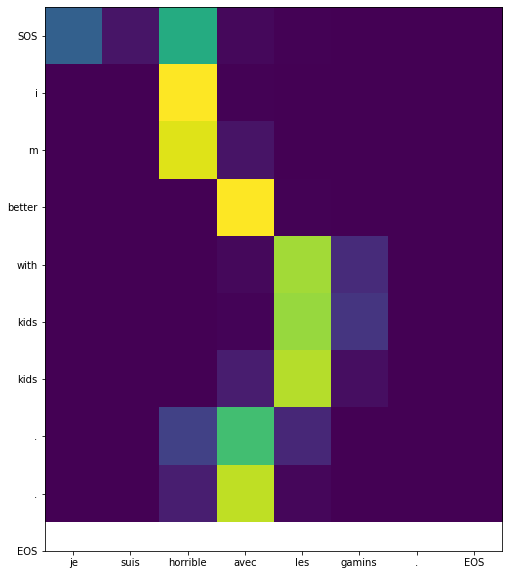

In [124]:
def generate_attention_matrix(x, y, lang1, lang2):
    encoder.eval()
    decoder.eval()
    x = x.view(-1, 1)
    input = encoder.embedding(x)
    x_len = torch.tensor([x.shape[0]])
    input = pack_padded_sequence(input, x_len)
    encoder_outputs, decoder_hidden = encoder(x, x_len) # last encoder hidden state becomes decoder hidden state
    y_pred = [english_lang.word2index['SOS']]
    decoder_input = torch.full((1, decoder_hidden.shape[1]), y_pred[-1])
    attention_weights = []
    while y_pred[-1]!=EOSToken: # 2 is the EOSToken
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        attention_weights.append(list(decoder.attn_weights.squeeze().detach().numpy()))
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        y_pred.append(topi.item())
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(attention_weights)
    x = [lang1.index2word[x[i, 0].item()] for i in range(len(x))]
    y_pred = [lang2.index2word[y_pred[i]] for i in range(len(y_pred))]
    ax.set_xticks(range(len(x)), labels=x)
    ax.set_yticks(range(len(y_pred)), labels=y_pred)
    
idx = random.randrange(len(dataset))
x, y = dataset[idx]
generate_attention_matrix(x, y, french_lang, english_lang)